In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from sklearn import linear_model as lm
from sklearn import preprocessing, model_selection
from sklearn import metrics


from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


%matplotlib inline

# Vinhos


## Leitura da Base 

In [2]:
df_wine = pandas.read_csv('../Data/dataset_vinhos.csv',sep=';')


wine_target_col = 'target'

wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()

drop_cols = ['target_label']
df_wine.drop(drop_cols, axis=1, inplace=True)
print(df_wine.shape)
df_wine.head()

(5320, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,red


# Transformação Variáveis Categóricas

In [3]:
categorical_cols = ['type']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_wine[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_wine = pandas.concat([df_wine, ohe_df], axis=1).drop(cname, axis=1)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type_red,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,1.0,0.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,1.0,0.0


## Treinamento Regressão Logística 

In [4]:

Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest


model_wine = lm.LogisticRegression(penalty='l2', solver='liblinear')
model_wine.fit(xtrain, ytrain)      
df_train['decision'] = model_wine.predict(xtrain)
df_test['decision']  = model_wine.predict(xtest)
df_train['probability'] = model_wine.predict_proba(xtrain)[:,1]
df_test['probability']  = model_wine.predict_proba(xtest)[:,1]

df_wine = pandas.concat((df_train, df_test), axis=0)

## Matriz de Confusão 

[Text(0, 0.5, 'baixa qualidade'), Text(0, 1.5, 'alta qualidade')]

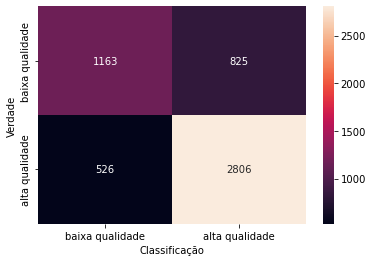

In [5]:
cm = metrics.confusion_matrix(df_wine[wine_target_col],
                              df_wine['decision'])

sns.heatmap(cm, annot=True, fmt = '.0f')

plt.xlabel('Classificação')
plt.ylabel('Verdade')
plt.gca().set_xticklabels(wine_label_map.target_label.values)
plt.gca().set_yticklabels(wine_label_map.target_label.values)

## Métricas de Classifição

In [6]:
print(metrics.classification_report(df_wine[wine_target_col],
                              df_wine['decision'],
                              target_names = wine_label_map.target_label))

                 precision    recall  f1-score   support

baixa qualidade       0.69      0.59      0.63      1988
 alta qualidade       0.77      0.84      0.81      3332

       accuracy                           0.75      5320
      macro avg       0.73      0.71      0.72      5320
   weighted avg       0.74      0.75      0.74      5320



## Distribuição de Probabilidade 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


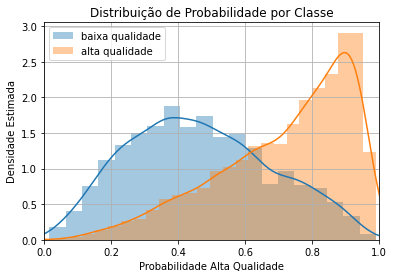

In [7]:
plt.figure(figsize=(6,4))
for i in wine_label_map.target.unique():
    sns.distplot(df_wine[df_wine[wine_target_col] == i].probability,
                 label=wine_label_map[wine_label_map.target == i].target_label,
                 ax = plt.gca())

plt.title('Distribuição de Probabilidade por Classe')
plt.ylabel('Densidade Estimada')
plt.xlabel('Probabilidade Alta Qualidade')
plt.xlim((0,1))
plt.grid()
plt.legend()

## Curva ROC 

Text(0, 0.5, 'Taxa de Detecção')

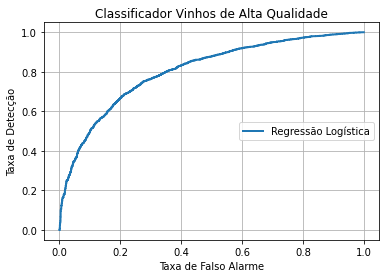

In [8]:
plt.figure(figsize=(6,4))

fpr, tpr, thr = metrics.roc_curve(df_wine[wine_target_col],
                                  df_wine['probability'])
plt.plot(fpr, tpr, '-', lw=2, label='Regressão Logística')

plt.legend(loc='right')
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

## Regime de Operação 

In [9]:
import warnings
warnings.filterwarnings('ignore')


def plot_operation_threshold(threshold):
    plt.figure(figsize=(12,4))
    # MATRIZ CONFUSAO
    plt.subplot(1,2,1)
    cm = metrics.confusion_matrix(df_wine[wine_target_col],
                                  df_wine['probability'] > threshold)
    sns.heatmap(cm, annot=True, fmt = '.0f')
    plt.xlabel('Classificação')
    plt.ylabel('Verdade')
    plt.gca().set_xticklabels(wine_label_map.target_label.values)
    plt.gca().set_yticklabels(wine_label_map.target_label.values)
    # DISTRIBUICAO PROBABILIDADES
    plt.subplot(1,2,2)
    for i in wine_label_map.target.unique():
        sns.distplot(df_wine[df_wine[wine_target_col] == i].probability,
                     label=wine_label_map[wine_label_map.target == i].target_label,
                     ax = plt.gca())
    plt.plot([threshold, threshold], [0, plt.axis()[3]], '--k', lw=2, label = 'Corte Operação')
    plt.title('Distribuição de Probabilidade por Classe')
    plt.ylabel('Densidade Estimada')
    plt.xlabel('Probabilidade Alta Qualidade')
    plt.xlim((-0.01,1.01))
    plt.grid()
    plt.legend()
    plt.show()
    # PRINT CLASSIFICATION REPORT
    print(metrics.classification_report(df_wine[wine_target_col],
                                        df_wine['probability'] > threshold,
                                        target_names = wine_label_map.target_label))    


interact(plot_operation_threshold, threshold=(0,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0), Output()), _dom_classes=('widg…

<function __main__.plot_operation_threshold(threshold)>

# Íris 

## Leitura dos Dados 

In [10]:
df_iris = pandas.read_csv('../Data/dataset_iris.csv',sep=';')

iris_label_map = df_iris[['target', 'target_label']].drop_duplicates()

drop_cols = ['target_label']
df_iris.drop(drop_cols, axis=1, inplace=True)

print(df_iris.shape)

iris_target_col = 'target'

df_iris.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Treinamento do Classificador 

In [11]:

Y = df_iris[iris_target_col]
X = df_iris.drop(iris_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[iris_target_col] = ytrain
df_test[iris_target_col] = ytest


model_iris = lm.LogisticRegression(penalty='l2', solver='liblinear')
model_iris.fit(xtrain, ytrain)      
df_train['decision'] = model_iris.predict(xtrain)
df_test['decision']  = model_iris.predict(xtest)
for icls in iris_label_map.target.unique():
    xclass = xtrain[ytrain==icls]
    idx = df_train[iris_target_col] == icls
    df_train.loc[idx,'probability'] = model_iris.predict_proba(xclass)[:,icls]
    xclass = xtest[ytest==icls]
    idx = df_test[iris_target_col] == icls
    df_test.loc[idx,'probability']  = model_iris.predict_proba(xclass)[:,icls]

df_iris = pandas.concat((df_train, df_test), axis=0)

## Matriz de Confusão 

[Text(0, 0.5, 'setosa'), Text(0, 1.5, 'versicolor'), Text(0, 2.5, 'virginica')]

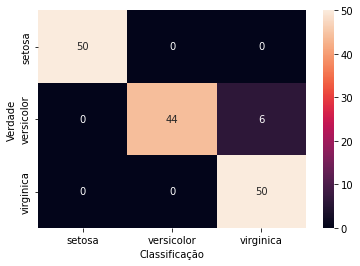

In [12]:
cm = metrics.confusion_matrix(df_iris[iris_target_col],
                              df_iris['decision'])
                              
sns.heatmap(cm, annot=True, fmt = '.0f')

plt.xlabel('Classificação')
plt.ylabel('Verdade')
plt.gca().set_xticklabels(iris_label_map.target_label.values)
plt.gca().set_yticklabels(iris_label_map.target_label.values)

## Relatório de Classificação 

In [13]:
print(metrics.classification_report(df_iris[iris_target_col],
                              df_iris['decision'],
                              target_names = iris_label_map.target_label))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       1.00      0.88      0.94        50
   virginica       0.89      1.00      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



## Distribuição de Probabilidade 

In [14]:

def plot_dist_class(class_name):
    iclass = iris_label_map[iris_label_map.target_label == class_name].target.values[0]
    prob = model_iris.predict_proba(X)[:,iclass]
    
    plt.figure(figsize=(6,4))
    for i in iris_label_map.target.unique():
        plt.hist(prob[Y == i], bins=np.linspace(0,1,10),
#                  histtype ='stepfilled',
                 alpha=0.3,
                 lw=2,
                 label=iris_label_map[iris_label_map.target == i].target_label)
                     
        
    plt.title('Distribuição de Probabilidade por Classe')
    plt.ylabel('Quantidade de Amostras')
    plt.xlabel('Probabilidade Espécie ' + class_name)
    plt.xlim((0,1))
    plt.grid()
    plt.legend()
    plt.show()

interact(plot_dist_class, class_name = iris_label_map.target_label) 


interactive(children=(Dropdown(description='class_name', options=('setosa', 'versicolor', 'virginica'), value=…

<function __main__.plot_dist_class(class_name)>

## Curva ROC 

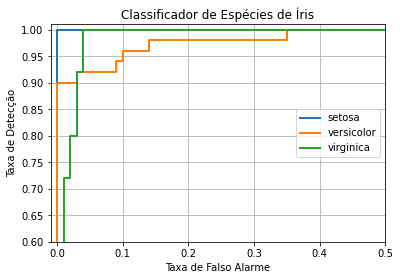

In [15]:
for class_name in iris_label_map.target_label:
    iclass = iris_label_map[iris_label_map.target_label == class_name].target.values[0]
    prob = model_iris.predict_proba(X)[:,iclass]
    clas = Y == iclass

    fpr, tpr, thr = metrics.roc_curve(clas,
                              prob)
    plt.plot(fpr, tpr, '-', lw=2, label=class_name)

plt.legend(loc='right')
plt.title('Classificador de Espécies de Íris')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')
plt.xlim((-0.01, 0.5))
plt.ylim((0.6, 1.01))
plt.show()
